## Analisis de Datos: Tendencia de Victimas de Secuestros a Nivel Nacional

De acuerdo a los datos abiertos de la fiscalia se pueden agrupar la cantidad de victimas por año de hecho referentes al delito asociado que en nuestro caso es el secuestro y desapariciones

El objetivo de este notebook es entrenar una red neuronal para encontrar la tendencia y predecir 5 años a futuro el numero de victimas por año

### Cantidad de Victimas por Año

In [1]:
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from model import ModeloSecuestros

### Secuestros por Año y Linea de Tendencia

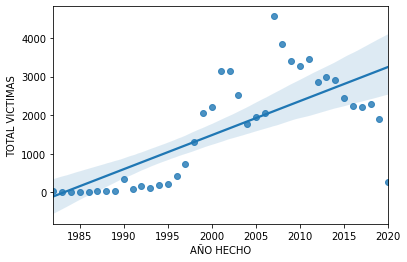

In [2]:
dfSecuestros = pd.read_csv('Datasets/victimasPorAño.csv')
dfSecuestros = dfSecuestros.rename(columns={'ANIO_HECHO':'AÑO HECHO','TOTAL_VICTIMAS':'TOTAL VICTIMAS'})
x,y = dfSecuestros['AÑO HECHO'], dfSecuestros['TOTAL VICTIMAS']
fig,ax = plt.subplots()
sns.regplot(x=x, y=y,)
fig.savefig('Gráficas/tendencia_datos.png',dpi=240)

### Modelo para predecir secuestros
### DataFrame 5 a 1 años

En este dataframe se representa lo siguiente:
- Input_0 -> Input_4 = Victimas por año en 5 años (ej: 1982 a 1986)
- Output_0 = Victimas en el año siguiente (ej: 1987)

In [3]:
datos_csv = 'Datasets/DataSetVictimasAnios5x1.csv'
df = pd.read_csv(datos_csv)
df

,Input_0,Input_1,Input_2,Input_3,Input_4,Output_0
0,24,1,1,3,11,45
1,1,1,3,11,45,46
2,1,3,11,45,46,42
3,3,11,45,46,42,358
4,11,45,46,42,358,92
5,45,46,42,358,92,171
6,46,42,358,92,171,101
7,42,358,92,171,101,187
8,358,92,171,101,187,209
9,92,171,101,187,209,430


### Construyendo el Modelo

### Modelo con Columnas Caracteristicas

In [4]:
modelo = ModeloSecuestros(csv=datos_csv, random_state = 1, inputs=['Input_{}'.format(i) for i in range(5)])

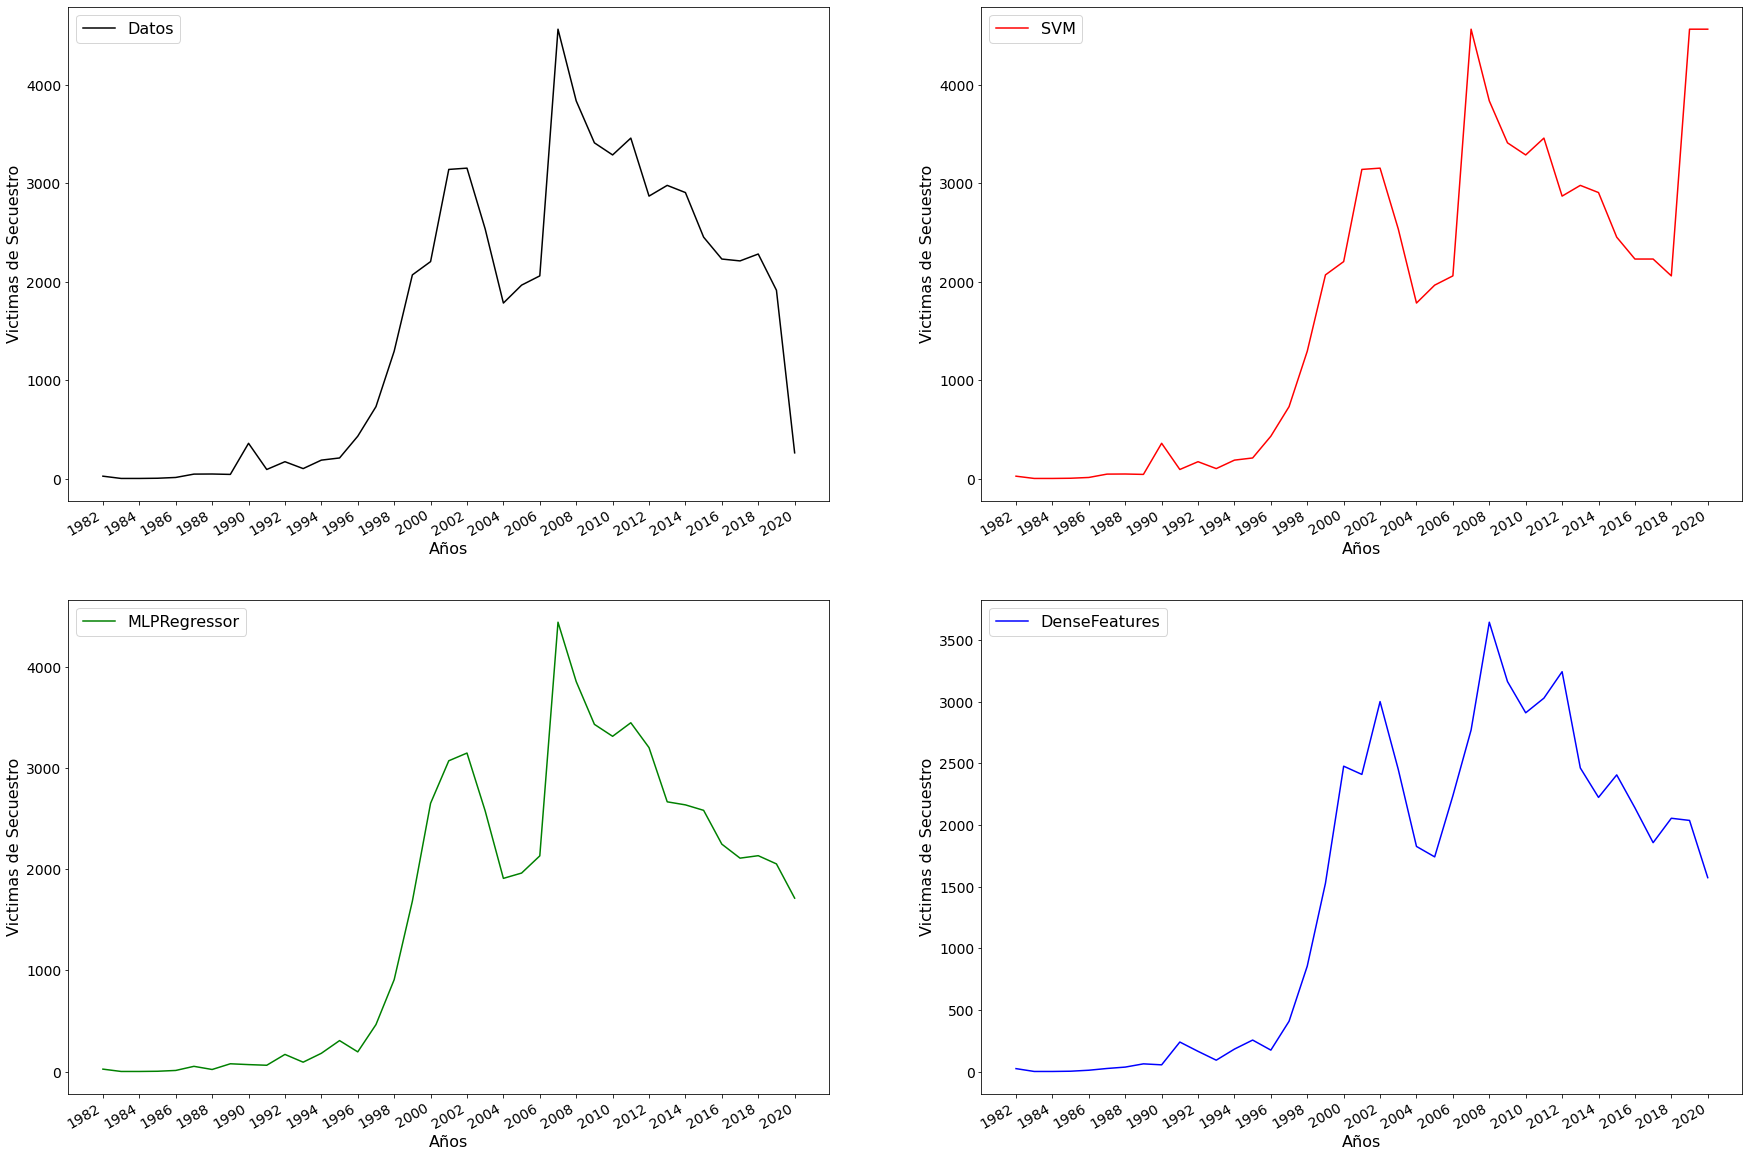

In [5]:
modelo.plot_in_time()

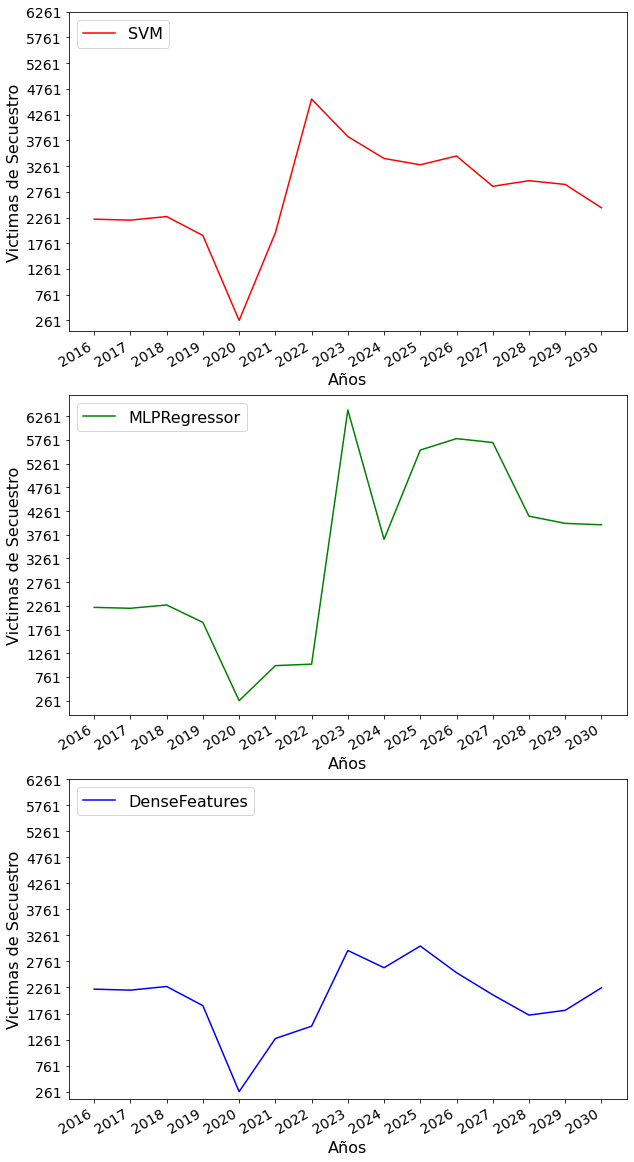

In [6]:
modelo.future()

In [7]:
modelo.get_feature_model().summary()
modelo.get_rmse_feature()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1800      
_________________________________________________________________
dense_1 (Dense)              multiple                  90300     
_________________________________________________________________
dense_2 (Dense)              multiple                  301       
Total params: 92,401
Trainable params: 92,401
Non-trainable params: 0
_________________________________________________________________


((2277.8133008070117,), 1857.8458628207025)

#### Grafico de Dispersión

RMSE. 2232.5095876218606


/mnt/d/Github/PaperSecuestros/model.py:170: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis([min_test,max_test,min_pred,max_pred ])


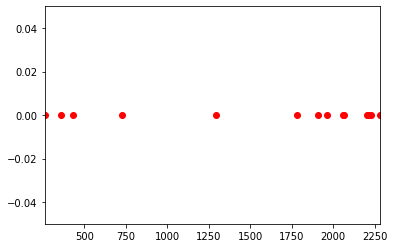

In [8]:
modelo.get_feature_scatter()

### Modelo con Capas Densas

In [9]:
modelo.get_sequential_model().summary()
modelo.get_rmse_sequential()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 317)               1902      
_________________________________________________________________
dense_4 (Dense)              (None, 164)               52152     
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 1320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 55,383
Trainable params: 55,383
Non-trainable params: 0
_________________________________________________________________


(865.6094924031607, 806.0680426959227)

#### Grafico de Dispersión

RMSE. 858.8188975354512


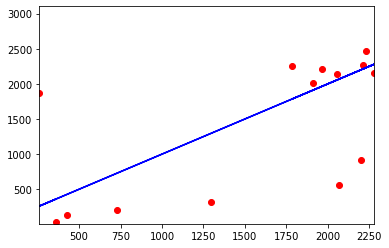

In [10]:
modelo.get_sequential_scatter()

### Maquina de Soporte Vectorial

In [11]:
modelo.get_svm_model()
modelo.get_rmse_svm()

(0.0, 2529.0635618742367)

### Gráfico de Dispersión

RMSE. 867.4616451938108


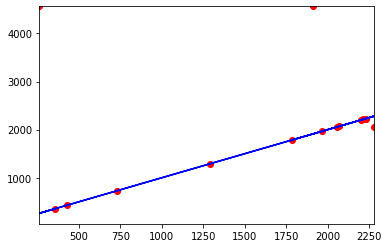

In [12]:
modelo.get_svm_scatter()

### Guardar y Cargar Modelos

In [13]:
modelo.load_mlp_model('mlp_235_736')
modelo.get_rmse_mlp()

(235.42367775447997, 735.719209232528)

RMSE. 335.53557980700145


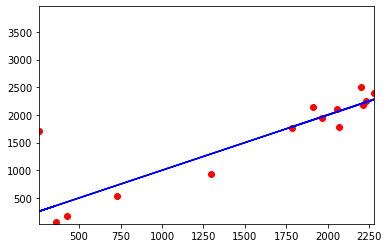

In [14]:
modelo.get_mlp_scatter()

In [15]:
modelo.mlp_description

{'hidden_layers': [175, 157, 207],
 'max_iter': 165,
 'activation': 'relu',
 'solver': 'adam'}